In [1]:
import os
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

In [2]:
data = pl.read_csv('./dataset/4.Fraud/Fraud.csv')
ip_map = pl.read_csv('./dataset/4.Fraud/IpAddress_to_Country.csv', schema_overrides={"lower_bound_ip_address": pl.Float64, 'upper_bound_ip_address': pl.Float64})

In [3]:
ip_map.head()

lower_bound_ip_address,upper_bound_ip_address,country
f64,f64,str
1.6777216e7,1.6777471e7,"""Australia"""
1.6777472e7,1.6777727e7,"""China"""
1.6777728e7,1.6778239e7,"""China"""
1.677824e7,1.6779263e7,"""Australia"""
1.6779264e7,1.6781311e7,"""China"""


In [4]:
ip_map = ip_map.with_columns(pl.col("lower_bound_ip_address").cast(pl.Int64))
ip_map = ip_map.with_columns(pl.col("upper_bound_ip_address").cast(pl.Int64))

In [5]:
ip_map.head()

lower_bound_ip_address,upper_bound_ip_address,country
i64,i64,str
16777216,16777471,"""Australia"""
16777472,16777727,"""China"""
16777728,16778239,"""China"""
16778240,16779263,"""Australia"""
16779264,16781311,"""China"""


In [6]:
data = data.drop('')

In [7]:
data = data.with_columns(pl.col("ip_address").cast(pl.Int64))
data = data.with_columns(pl.col('signup_time').str.to_datetime())
data = data.with_columns(pl.col('purchase_time').str.to_datetime())

In [8]:
data = data.with_columns(
    (pl.col('purchase_time') - pl.col('signup_time')).dt.total_seconds().alias('dtime')
)

# find country from ip address

In [9]:
data = data.sort('ip_address')
ip_map = ip_map.sort('lower_bound_ip_address')

In [10]:
data = data.join_asof(
    ip_map,
    left_on="ip_address",
    right_on="lower_bound_ip_address",
    strategy="backward"
)

In [11]:
data = data.with_columns([
    pl.when(pl.col("ip_address") > pl.col("upper_bound_ip_address"))
      .then(None)
      .otherwise(pl.col("country"))
      .alias("country")
]).drop([
    'lower_bound_ip_address', 'upper_bound_ip_address'
])

In [12]:
data.head()

user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,dtime,country
i64,datetime[μs],datetime[μs],i64,str,str,str,str,i64,i64,i64,i64,str
62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,"""ZCLZTAJPCRAQX""","""Direct""","""Safari""","""M""",36,52093,0,1763014,null
173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,"""YFGYOALADBHLT""","""Ads""","""IE""","""F""",30,93447,0,1084823,null
242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,"""QZNVQTUITFTHH""","""Direct""","""FireFox""","""F""",32,105818,0,749320,null
370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,"""PIBUQMBIELMMG""","""Ads""","""IE""","""M""",40,117566,0,7434634,null
119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,"""WFIIFCPIOGMHT""","""Ads""","""Safari""","""M""",38,131423,0,1407619,null


In [13]:
data.describe()

statistic,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,dtime,country
str,f64,str,str,f64,str,str,str,str,f64,f64,f64,f64,str
"""count""",151112.0,"""151112""","""151112""",151112.0,"""151112""","""151112""","""151112""","""151112""",151112.0,151112.0,151112.0,151112.0,"""129146"""
"""null_count""",0.0,"""0""","""0""",0.0,"""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,"""21966"""
"""mean""",200171.04097,"""2015-04-20 00:56:09.511329""","""2015-06-16 02:56:38.759952""",36.935372,null,null,null,null,33.140704,2.1521e9,0.093646,4.9320e6,null
"""std""",115369.285024,null,null,18.322762,null,null,null,null,8.617733,1.2485e9,0.291336,3.1263e6,null
"""min""",2.0,"""2015-01-01 00:00:42""","""2015-01-01 00:00:44""",9.0,"""AAALBGNHHVMKG""","""Ads""","""Chrome""","""F""",18.0,52093.0,0.0,1.0,"""Afghanistan"""
"""25%""",100643.0,"""2015-02-18 09:53:01""","""2015-04-18 14:41:31""",22.0,null,null,null,null,27.0,1.0859e9,0.0,2.18676e6,null
"""50%""",199959.0,"""2015-04-19 04:41:49""","""2015-06-18 13:46:47""",35.0,null,null,null,null,33.0,2.1548e9,0.0,4.926348e6,null
"""75%""",300052.0,"""2015-06-18 14:47:03""","""2015-08-17 18:48:31""",49.0,null,null,null,null,39.0,3.2433e9,0.0,7.644523e6,null
"""max""",400000.0,"""2015-08-18 04:40:29""","""2015-12-16 02:56:05""",154.0,"""ZZZXASJUVUNMV""","""SEO""","""Safari""","""M""",76.0,4.2949e9,1.0,1.0367972e7,"""Zimbabwe"""


In [14]:
ip_counts = data['ip_address'].value_counts().rename(
    {'count': 'ip count'}
)
ip_counts.head()

ip_address,ip count
i64,u32
52093,1
93447,1
105818,1
117566,1
131423,1


In [15]:
device_counts = data['device_id'].value_counts().rename(
    {'count': 'device count'}
)
device_counts.head()

device_id,device count
str,u32
"""EOMIKCPAONNZI""",1
"""PQYCFSGTBAPBX""",1
"""NIGKVVEMSNYEU""",1
"""VBVFGQNWUOXNV""",1
"""IUELQQQGOAYXY""",1


In [16]:
data = data.join(ip_counts, on="ip_address", how="left") \
    .join(device_counts, on="device_id", how="left")

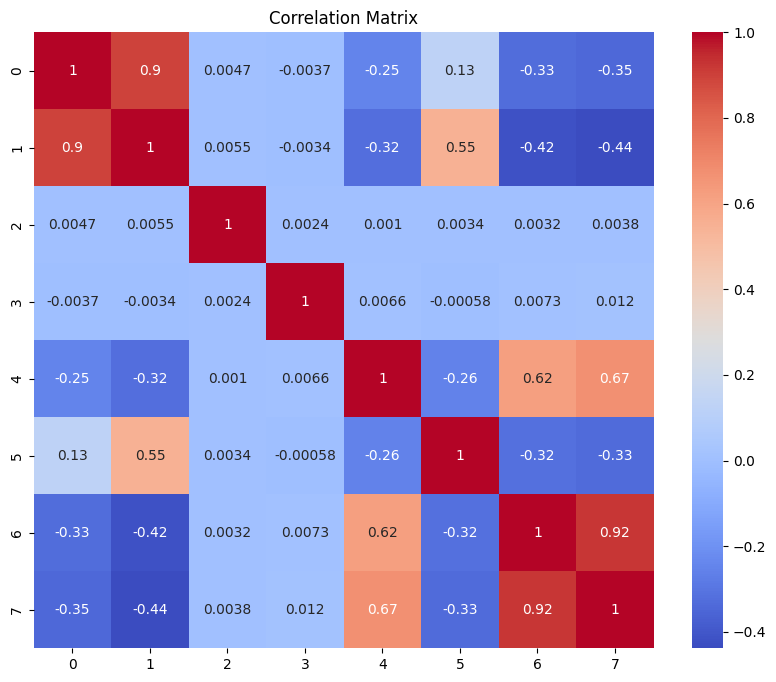

In [17]:
data_cor = data.drop(['user_id', 'device_id', 'source', 'browser', 'sex', 'country', 'ip_address'])
plt.figure(figsize=(10, 8))
sns.heatmap(data_cor.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

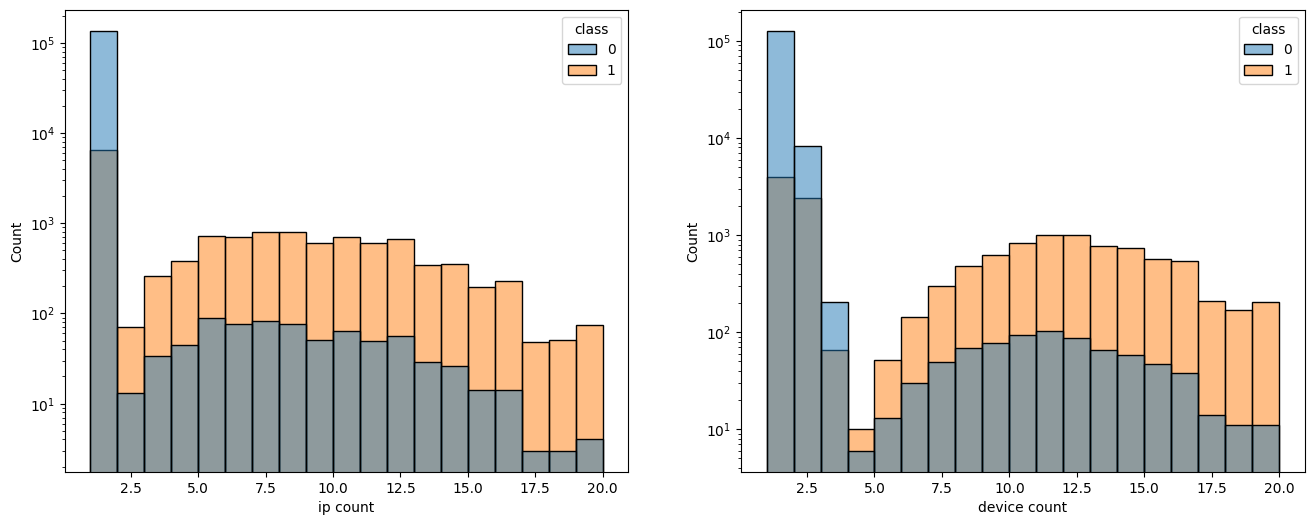

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(data=data, x='ip count', hue='class', ax=ax[0])
sns.histplot(data=data, x='device count', hue='class', ax=ax[1])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
plt.show()

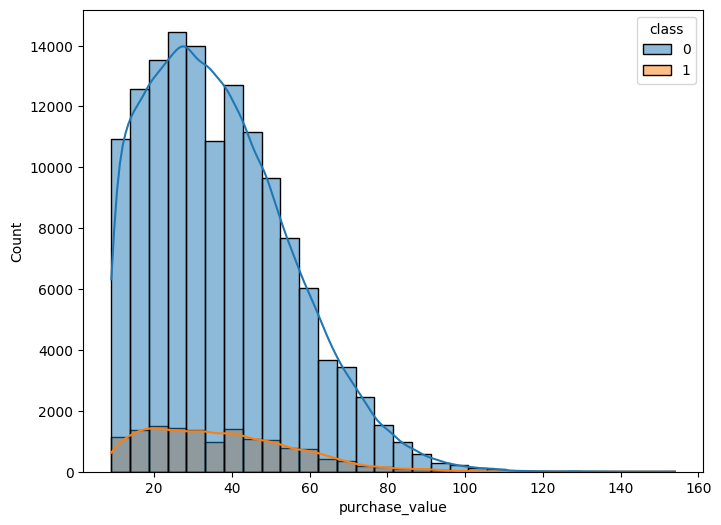

In [19]:
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='purchase_value', hue='class', bins=30, kde=True)
plt.show()

In [20]:
data.columns

['user_id',
 'signup_time',
 'purchase_time',
 'purchase_value',
 'device_id',
 'source',
 'browser',
 'sex',
 'age',
 'ip_address',
 'class',
 'dtime',
 'country',
 'ip count',
 'device count']

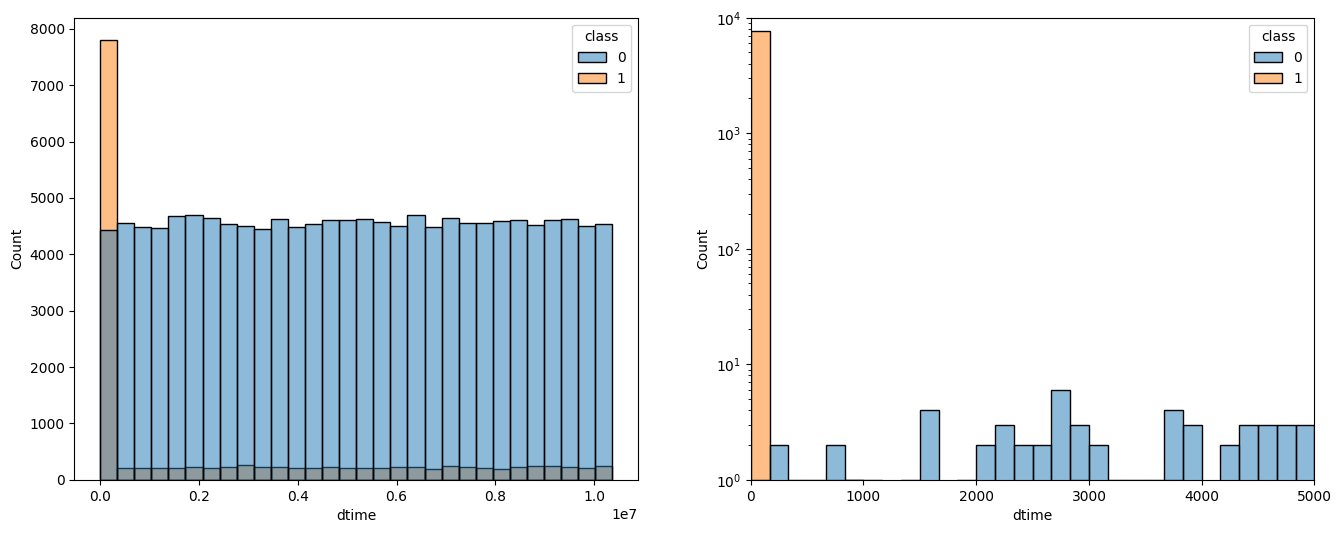

In [21]:
zoomin = 5e3
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(data=data, x='dtime', hue='class', bins=30, ax=ax[0])
sns.histplot(data=data, x='dtime', hue='class', bins=30, binrange=(0, zoomin), ax=ax[1])
ax[1].set_xlim(0, zoomin)
ax[1].set_ylim(1, 1e4)
ax[1].set_yscale('log')
plt.show()

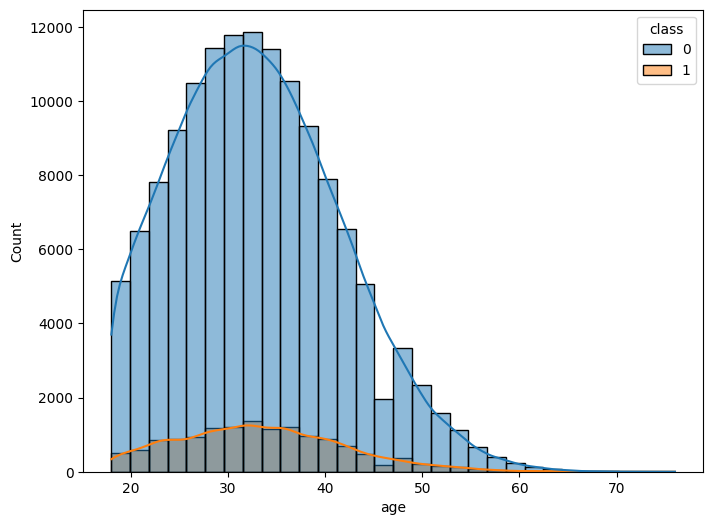

In [22]:
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='age', hue='class', bins=30, kde=True)
plt.show()

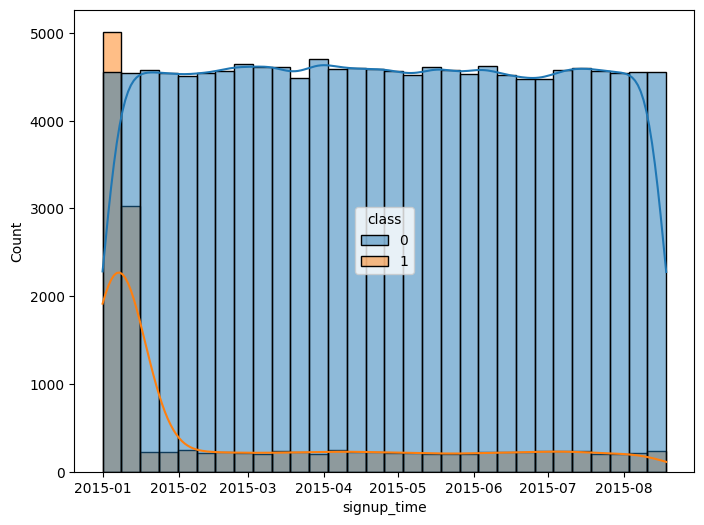

In [23]:
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='signup_time', hue='class', bins=30, kde=True)
plt.show()

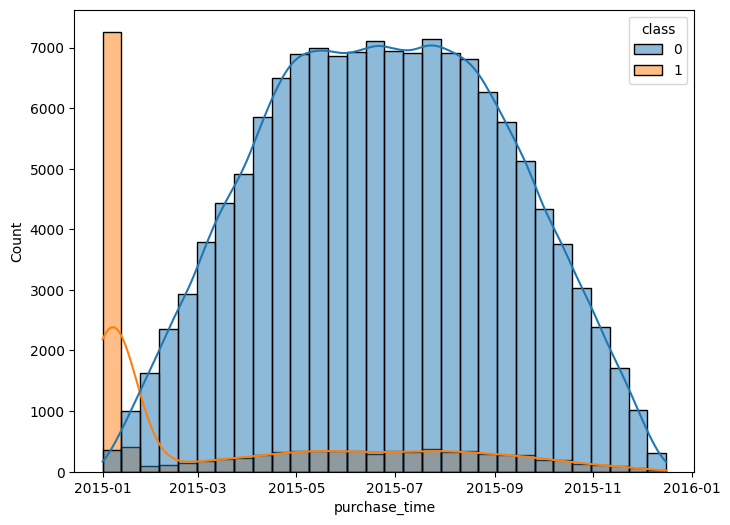

In [24]:
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='purchase_time', hue='class', bins=30, kde=True)
plt.show()

In [44]:
data.group_by("source").agg([
    pl.len().alias("total"),
    pl.col("class").eq(1).sum().alias("count_class_1")
]).with_columns(
    (pl.col("count_class_1") / pl.col("total")).alias("portion")
).select(["source", "portion"])

source,portion
str,f64
"""Direct""",0.10537
"""Ads""",0.092066
"""SEO""",0.089285


<Axes: xlabel='source', ylabel='count'>

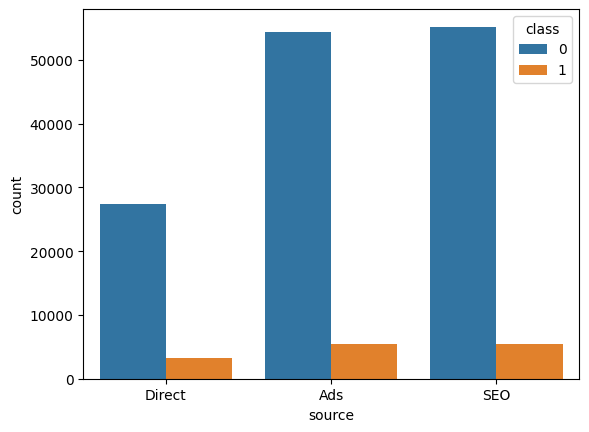

In [25]:
sns.countplot(x='source', hue='class', data=data)

In [46]:
data.group_by("browser").agg([
    pl.len().alias("total"),
    pl.col("class").eq(1).sum().alias("count_class_1")
]).with_columns(
    (pl.col("count_class_1") / pl.col("total")).alias("portion")
).select(["browser", "portion"])

browser,portion
str,f64
"""IE""",0.086775
"""Safari""",0.090201
"""FireFox""",0.095165
"""Chrome""",0.098792
"""Opera""",0.089227
